In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataframe imports
import json
import time
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
import itertools

# Plotting imports and defaults setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl

SMALL_SIZE = 18
MEDIUM_SIZE = 26
BIGGER_SIZE = 30

mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)

%matplotlib inline

# Scientific imports
import numpy as np
import networkx as nx

# Utilities
import itertools
import time
from datetime import datetime, timedelta

a4_dims = (11.7, 8.27)



In [2]:
events = {'2016-11-09': 'Trump wins election', \
          '2017-08-11': 'Unite the Right rally', \
          '2017-11-21': 'Plan to repeal net neutrality', \
          '2017-12-18': 'Twitter suspends white nationalists', \
          '2018-01-12': 'Trump "shithole" comment', \
          '2018-03-01': 'Gilmore lawsuit against Alex Jones'}

In [2]:
peak_dates = ["2016-11-23 23:00:00", "2017-08-22 23:00:00","2016-12-01 23:00:00","2017-12-23 23:00:00",
 "2016-12-13 23:00:00", "2017-09-09 23:00:00", "2017-06-06 23:00:00", "2018-03-06 23:00:00",
 "2017-11-25 23:00:00", "2017-05-24 23:00:00"]

# Basic network statistics

Firstly we look at the number of nodes, number of edges and average degree for each window size for the whole period. Note that "number of nodes" means number of individuals who were involved in at least one interaction within the relevant period.

In [12]:
def fullPlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000, 86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_yscale(scale)

    with open('degree/degrees.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        x = x[x[toPlot] != 0]
        #x.plot(x='time', y=toPlot,ax=ax, label="Aggregate Graph")

    with open('degree/degreewindows.json') as json_file:
        with open('degree/degreesorted.json') as json_2:
            cc1 = json.load(json_file)
            cc2 = json.load(json_2)
            cc1= pd.DataFrame(cc1['views'])
            cc2= pd.DataFrame(cc2['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc2['time'] = pd.to_datetime(cc2['time'],unit='ms')
            cc1.set_index('time', inplace=False)
            cc2.set_index('time', inplace=False)
            index = 0
            for i in windows:
                color=next(ax._get_lines.prop_cycler)['color']
                y = cc1[cc1['windowsize'] == i]
                mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(microseconds=1000*i))
                y=y[mask]
                y['time'] = y['time'] - timedelta(microseconds=500*i)
                z = cc2[cc2['windowsize'] == i]
                y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
                z['avgdeg']= np.where(z['vertices']<1, z['vertices'], 2*z['edges']/z['vertices'])
                #y = y[y[toPlot] != 0]
                y.plot(x='time',y=toPlot,ax=ax, label=labels[index], color = color, linewidth=3)
                #z.plot(x='time', y=toPlot,ax=ax, label='_nolegend_', color = color, linestyle="--", alpha=0.8)
                index +=1

    with open('degree/degreehours.json') as json_file:
        with open('degree/degreesortedhour.json') as json_2:
            color=next(ax._get_lines.prop_cycler)['color']
            x = json.load(json_file)
            y = json.load(json_2)
            x= pd.DataFrame(x['views'])
            y= pd.DataFrame(y['views'])
            x['index'] = pd.to_datetime(x['time'],unit='ms')
            y['index'] = pd.to_datetime(y['time'],unit='ms')
            x['time'] = pd.to_datetime(x['time'],unit='ms')
            y['time'] = pd.to_datetime(y['time'],unit='ms')
            x.set_index('index', inplace=True)
            y.set_index('index', inplace=True)
            mask = (x['time'] > start) & (x['time'] < end) & (x['time'] > x.iloc[0]['time'] + timedelta(microseconds=1000*3600000))
            x =x[start:end]
            y =y[start:end]
            y['time'] = y['time'] - timedelta(microseconds=500*3600000)
            x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
            y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
            x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
            y['hour'] = y.apply(lambda row: int(row['time'].hour),axis=1)
            x = x[x[toPlot] != 0]
            y = y[y[toPlot] != 0]
            x.plot(x='time', y=toPlot,ax=ax, color=color, linewidth=3, label="Hour window")
            #y.plot(x='time', y=toPlot,ax=ax, color=color, label='_nolegend_',linestyle="--", alpha=0.8)
        
    #plt.axvline('2016-11-09',linestyle='')
    #plt.axvline('2017-08-11')
    #plt.axvline('2017-08-13')
    plt.legend(fontsize=20, loc='upper left')
    #plt.xlim(start,end)
    plt.xlabel('Date')
    plt.rc('xtick')
    plt.rc('ytick')
    plt.savefig('graphs/'+toPlot+'def1.png')
    plt.show()

In [3]:
def plot_window_scale():
    toPlot=['vertices','edges','avgdeg']
    labels=['Number of Nodes', 'Number of Edges', 'Average Degree']
    start, end = '2016-07-30 23:00:00','2018-05-30'
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel("Window size (hours)",fontsize=30)
    plt.ylabel('Size of quantity',fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    windows = np.array([3600000, 86400000, 604800000, 2592000000, 31536000000])
    means = np.zeros((3,5),dtype=float)
    sds = np.zeros((3,5),dtype=float)

    with open('degree/degreewindows.json') as json_file:            
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        print(x.iloc[0])
        print(x.iloc[-1])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        for j in range(1,5):
            z = x[x['windowsize']==round(windows[j])]
            mask = (z['time']>start) & (z['time'] < end) & (z['time'] > z.iloc[0]['time'] + timedelta(microseconds=1000*int(windows[j])))
            z = z[mask]
            for i in range(3):
                means[i,j]=z[toPlot[i]].mean()
                sds[i,j]=z[toPlot[i]].std()
                
    with open('degree/degreehours.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        mask = (x['time'] > start) & (x['time'] < end) & (x['time'] > x.iloc[0]['time'] + timedelta(microseconds=1000*3600000))
        x = x[mask]
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        for i in range(3):
            means[i,0]=x[toPlot[i]].mean()
            sds[i,0]=x[toPlot[i]].std()
        
    windows = windows/3600000
    
    for i in range(3):
        plt.plot(windows, means[i], label = labels[i],marker='^')
        plt.fill_between(windows, means[i]-sds[i], means[i]+sds[i], alpha = 0.3)
    
    plt.legend(loc='upper left',fontsize=20)
    plt.savefig('Graphs/windowscale.png')
    plt.show()

## Number of nodes

First we examine how the number of nodes is reported according to each window size. We see that:
* The values for the year and the month window diverge by huge scales. This suggests that there is an important distinction to be made about reported "total" number of users vs "active" number of users for social networks.
* On medium scales of a month and week, we see 'bumps' following news events of interest to the Gab community such as the Trump election in Nov 16 and Charlottesville "Unite the Right" rally in Aug 17, which seem to be obscured in larger timescales and just noise in smaller scales. Perhaps weekly/monthly windows are a good candidate size for time series anomaly detection tasks?

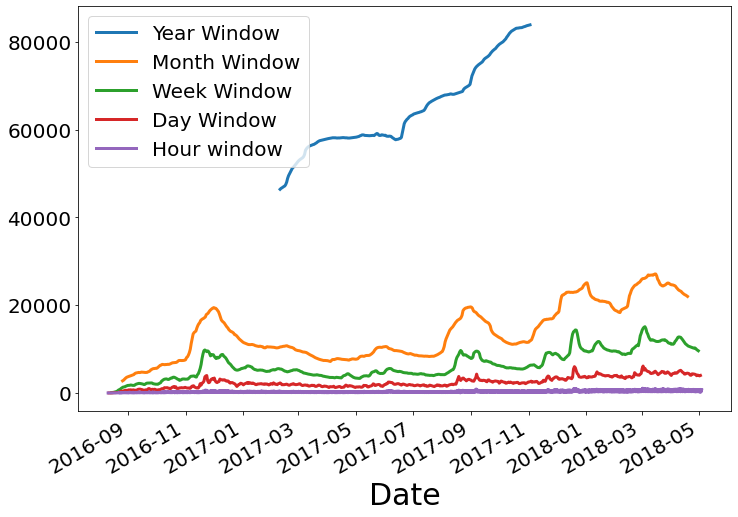

In [13]:
fullPlot('vertices','Total Number of Vertices','Date','Number of Vertices','linear','2016-07-30 23:00:00','2018-05-30')

time          1470783600000
windowsize      31536000000
vertices                  0
edges                     0
degree                    0
bestusers                []
viewTime              10426
concatTime                8
Name: 0, dtype: object
time                                              1525368897000
windowsize                                            604800000
vertices                                                   9604
edges                                                     78482
degree                                                        8
bestusers     [{'id': 31, 'indegree': 1026, 'outdegree': 35}...
viewTime                                                    884
concatTime                                                    1
Name: 2530, dtype: object


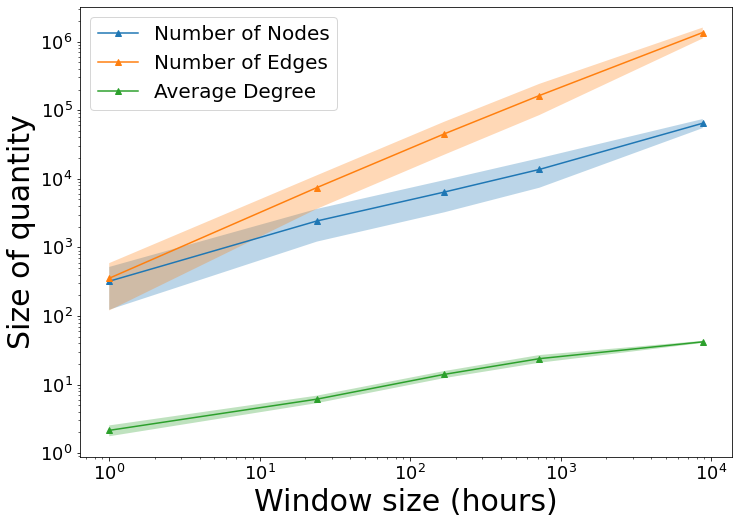

In [5]:
plot_window_scale()

## Number of edges

Not much to say here apart from, again, the hugely differing scales of looking at a month vs a year.

In [ ]:
fullPlot('edges', 'Total Number of Edges', 'Date', 'Edges', 'linear','2016-09-30 23:00:00','2018-10-30')

In [ ]:
plot_window_scale('edges', "Mean number of Edges", "Mean number of Edges", 1)

## Average degree

Calculated as 2x|edges|/|vertices|. We see that:
* For medium sized windows this is largely varying, with the 'dips' being caused by the bursts in number of vertices.
* For daily and hourly windows, it seems to be just constant + random noise (or constant+seasonal, I haven't looked into it yet.) It just seems interesting to me that there's seemingly no trend for the hour one compared to other sizes.

In [ ]:
fullPlot('avgdeg', 'Average Degree', 'Date', 'Average Degree', 'linear','2016-09-30 23:00:00','2018-10-30')

In [4]:
plot_window_scale('avgdeg', "Average Degree", "Average Degree", 5)

TypeError: plot_window_scale() takes 0 positional arguments but 4 were given

In [9]:
from matplotlib import gridspec
from matplotlib import ticker as mticker

def plotNewVsExisting(toPlot,start,end,y,scale):
    wide = (15,10)
    windows = [2592000000,604800000, 86400000]
    labels = ['Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig = plt.figure(figsize=a4_dims)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
    ax0 = fig.add_subplot(gs[0])
    ax0.set_ylim((0,1))
    ax1 = fig.add_subplot(gs[1],sharex=ax0)
    formatter = mticker.ScalarFormatter(useMathText=True)
    ax1.yaxis.set_major_formatter(formatter)
    plt.xlabel("Date")
    ax1.set_ylabel(y, labelpad=15)
    ax0.set_yscale(scale)
    
    color=next(ax1._get_lines.prop_cycler)['color']

    with open('degree/degrees.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        aggr =x[start:end]
        aggr.plot(y=toPlot,ax=ax1, label="Aggregate Graph", linestyle='--', color='black')
        
    with open('degree/degreewindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        index = 0
        for i in windows:
            diff_size = int(i/86400000);
            color=next(ax1._get_lines.prop_cycler)['color']
            y = cc1[cc1['windowsize'] == i]
            y['new']= aggr[toPlot].diff(diff_size)
            mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(microseconds=1000*i))
            y=y[mask]
            y['propNew'] = np.where(y[toPlot]<1,1,y['new']/y[toPlot])
            y['time'] = y['time'] - timedelta(microseconds=500*i)
            y.drop(columns=["bestusers"])
            y.set_index('time',inplace=True)
            #y['peaks']=y['propNew'][(y['propNew'].shift(1) < y['propNew']) & (y['propNew'].shift(-1)<y['propNew'])]
            #print(y['peaks'].dropna().sort_values(ascending=False))
            y.to_csv("degree/"+toPlot+"newvsexisting"+str(i)+".csv")
            y = y[y[toPlot] != 0]
            y.plot(y=toPlot,ax=ax1, label=labels[index], color = color, linewidth=3)
            y.plot(y="propNew",ax=ax0, label=labels[index], color = color, linewidth=3)
            #z.plot(x='time', y=toPlot,ax=ax, label='_nolegend_', color = color, linestyle="--", alpha=0.8)
            index +=1
                
    otherwindows = [15768000000, 7884000000]
    otherlabels = ['6 Month Window', '3 Month Window']
    with open('degree/2-3-4-6monthdegreerankingretry.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        index = 0
        for i in otherwindows:
            diff_size = int(i/86400000);
            color=next(ax1._get_lines.prop_cycler)['color']
            y = cc1[cc1['windowsize'] == i]
            y['new']= aggr[toPlot].diff(diff_size)
            mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(microseconds=1000*i))
            y=y[mask]
            y['propNew'] = np.where(y[toPlot]<1,1,y['new']/y[toPlot])
            y['time'] = y['time'] - timedelta(microseconds=500*i)
            y.set_index('time',inplace=True)
            #y['isLocalPeak']=y['prop_new'][(y['prop_new'].shift(1) < y['prop_new']) & (y['prop_new'].shift(-1)<y['prop_new'])]
            #print(y['peaks'].dropna().sort_values(ascending=False))
            y.to_csv("degree/"+toPlot+"newvsexisting"+str(i)+".csv")
            y.drop(columns=["bestusers"])
            y = y[y[toPlot] != 0]
            y.plot(y=toPlot,ax=ax1, label=otherlabels[index], color = color, linewidth=3)
            y.plot(y="propNew",ax=ax0, label=otherlabels[index], color = color, linewidth=3)
            #z.plot(x='time', y=toPlot,ax=ax, label='_nolegend_', color = color, linestyle="--", alpha=0.8)
            index +=1        
                
#     with open('degree/degreehours.json') as json_file:
#         with open('degree/degreesortedhour.json') as json_2:
#             color=next(ax1._get_lines.prop_cycler)['color']
#             x = json.load(json_file)
#             y = json.load(json_2)
#             x= pd.DataFrame(x['views'])
#             y= pd.DataFrame(y['views'])
#             x['index'] = pd.to_datetime(x['time'],unit='ms')
#             y['index'] = pd.to_datetime(y['time'],unit='ms')
#             x['time'] = pd.to_datetime(x['time'],unit='ms')
#             y['time'] = pd.to_datetime(y['time'],unit='ms')
#             x.set_index('index', inplace=True)
#             y.set_index('index', inplace=True)
#             x =x[start:end]
#             y =y[start:end]
#             #x['prop_new'] = np.where(x[toPlot]<1,1,x['new']/x[toPlot])
#             x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
#             y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
#             x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
#             y['hour'] = y.apply(lambda row: int(row['time'].hour),axis=1)
#             x = x[x[toPlot] != 0]
#             y = y[y[toPlot] != 0]
#             x['time'] = x['time'] - timedelta(microseconds=500*3600000)
#             x.plot(x='time', y=toPlot,ax=ax1, color=color, label="Hour window", linewidth=3)
#             #x.plot(x='time', y="prop_new",ax=ax0, color=color, label="Hour window")
#             #y.plot(x='time', y=toPlot,ax=ax, color=color, label='_nolegend_',linestyle="--", alpha=0.8)
    
    if toPlot=='vertices':
        height=100000
    else:
        height=2500000
        
    index=1
    for peak in peak_dates:
        newpeak = datetime.strptime(peak, "%Y-%m-%d %H:%M:%S") - timedelta(days=3.5)
        #print(str(index)+" "+str(newpeak))
        ax0.axvline(x=newpeak, color='black', alpha=0.3, linewidth=3)
        ax1.axvline(x=newpeak, color='black', alpha=0.3, linewidth=3)
        ax0.text(newpeak, 0.8, str(index), rotation=30, fontsize=15)
        ax1.text(newpeak, height, str(index), rotation=30, fontsize=15)
        index+=1
        
    ax0.get_legend().remove()
    
    handles,labels = ax1.get_legend_handles_labels()
    l1, l2, l3 = handles[:1], handles[1:4], handles[4:]
    handles = l1 + l3 + l2
    l1, l2, l3 = labels[:1], labels[1:4], labels[4:]
    labels = l1 + l3 + l2
    
    ax0.grid(False)
    ax1.grid(False)
    ax0.set_title("Proportion of "+toPlot+" that are new", fontsize=20)
    ax1.legend(handles, labels, loc='center left')
    plt.xlabel('Date')
    fig.tight_layout()
    plt.savefig('graphs/'+toPlot+'newVsExisting.png')
    plt.show()

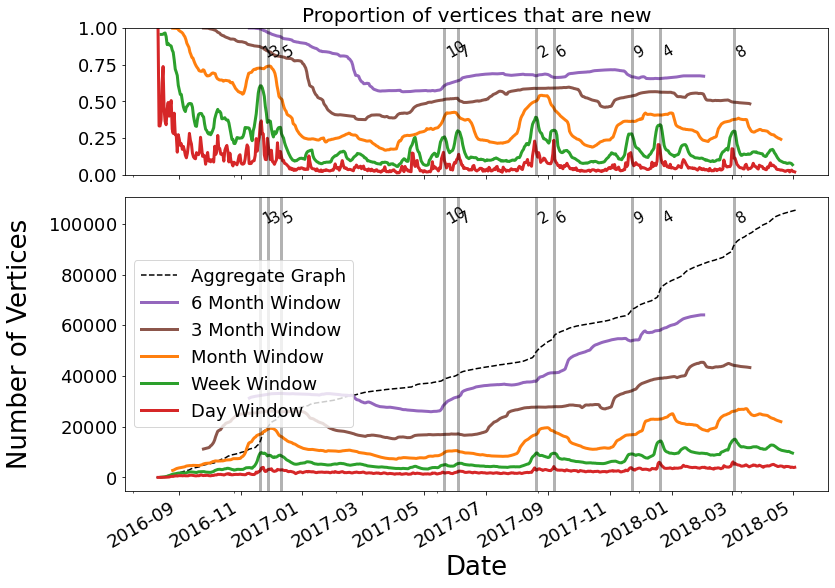

In [10]:
plotNewVsExisting("vertices","2016-06-30 23:00:00","2018-10-30","Number of Vertices","linear")

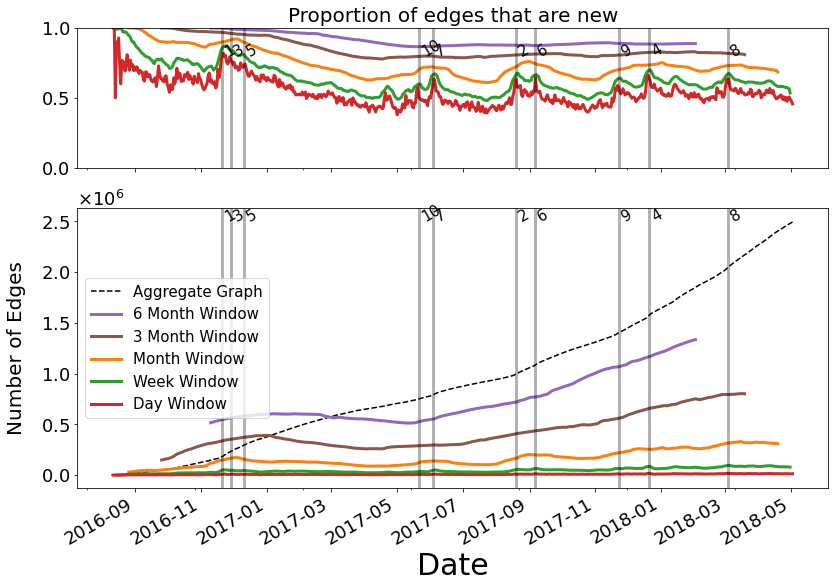

In [8]:
plotNewVsExisting("edges","2016-06-30 23:00:00","2018-10-30","Number of Edges","linear")

In [ ]:
def activeUserPlot(toPlot):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 4.11)
    fig, ax = plt.subplots(figsize=a4_dims)
    start, end = '2016-07-30 23:00:00','2018-05-30'
    
    with open('degree/degrees.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        total =x[start:end][toPlot]
        json_file.close()
        
    with open('degree/degreewindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1 = cc1[start:end]
        index=0
        for i in windows:
            if index==3:
                total.drop(total.tail(1).index,inplace=True)
            color=next(ax._get_lines.prop_cycler)['color']
            y = cc1[cc1['windowsize'] == i]
            print(len(y))
            y['prop'] = np.where(total < 1, total, y[toPlot]/total)
            mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=1000*i))
            y=y[mask]
            y['time'] = y['time'] - timedelta(microseconds=500*i)
            y.set_index('time',inplace=True)
            y.plot(y='prop',ax=ax, label=labels[index], color = color, linewidth=3)
            print(y['prop'].mean())
            index+=1
      
    plt.ylabel('Proportion of userbase active',fontsize=20)
    plt.xlabel('Date',fontsize=30)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.savefig('graphs/'+toPlot+'ProportionActive.png')
    plt.show()

In [ ]:
activeUserPlot('vertices')

# Connected Components Analysis

This section contains the analysis of the size/proportion of the largest connected components, as well as the number of connected components. In the proportion and number, we exclude components comprising just one edge (two nodes) from the calculations.

In [ ]:
def fullPlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)

    with open('CC/nowindow.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x = x[x['total'] != 0]
        x['mean'] = x[toPlot].rolling(window=4,center=False).mean()
        x.plot(x='time', y=toPlot,ax=ax, color='black', linewidth=3, label="Aggregate Graph")

    with open('CC/bigCC.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        cc1 = cc1[cc1[toPlot] != 0]
        index = 0
        for i in windows:
            y = cc1[cc1['windowsize'] == i]
            y['mean'] = y[toPlot].rolling(window=4,center=False).mean()
            hours = str(int((i/3600000)))+" hour window"
            y.plot(x='time', y=toPlot,ax=ax, linewidth=3, label=labels[index])
            index +=1

    with open('CC/cc1hour.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        #x = x[x['hour'].isin([4,16])]
        x.plot(x='time', y=toPlot,ax=ax, linewidth=3, label="Hour window")
    ax.legend(fontsize=20,framealpha=0.9,loc='upper left')
    plt.tight_layout()
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.xlabel("Date")
    plt.savefig("Graphs/"+toPlot+"partial.png")
    plt.show()

    
partial_dates = ['2017-09-30 23:00:00','2017-10-30']
full_dates = ['2016-09-30 23:00:00','2018-10-30']
#x['mean'] = x[toPlot].rolling(window=24,center=False).mean()
#[0,4,8,12,16,20,24]
#'2016-07-01': '2018-05-03'

## Proportion (without isolated nodes)

We measure the size of the largest connected component as a proportion of the size of the whole graph for that window.

### Whole time period

We find that:
* Just a day-length window is large enough to observe a connected component that is always more than 90% of the graph.
* Hourly window is a total mess, look into this later.

In [ ]:
fullPlot('proportionWithoutIslands','Largest Connected Component % of Graph','Date','Proportion of Graph','linear','2016-09-30 23:00:00','2018-10-30')

### Zoomed in

When zooming in to just a month subset of data, we see that the hourly window size is actually showing diurnal behaviour which we will explore later.

In [ ]:
fullPlot('proportionWithoutIslands','Largest Connected Component % of Graph','Date','Proportion of Graph','linear','2017-09-30 23:00:00','2017-10-30')

## Size of the largest connected component

On the whole, this shows similar behaviour to just the number of vertices.

In [ ]:
fullPlot('biggest','Largest Connected Component Size','Date','Largest connected Component','linear','2016-09-30 23:00:00','2018-10-30')

## Number of connected components

This seems to be similar in trend to the size of the largest (note the much smaller scale of ~600 components in total). 

In [ ]:
fullPlot('total','Number of Connected Components','Date','Total Connected Components','linear','2016-09-30 23:00:00','2018-10-30')

## At what size does the giant component break?

The plot below shows a CDF of the 'proportion' data for different window sizes, with particular attention to sizes between an hour and a day. Would be maybe helpful to provide a takeaway statistic like "for all window sizes, there's a component of size x% for y% of the time.

DatetimeIndex(['2016-08-10 14:00:00', '2016-08-10 15:00:00',
               '2016-08-10 16:00:00', '2016-08-10 22:00:00',
               '2016-08-11 08:00:00', '2016-08-12 02:00:00',
               '2016-08-13 16:00:00', '2016-08-13 21:00:00',
               '2016-08-14 00:00:00', '2016-08-14 09:00:00',
               ...
               '2018-05-03 09:00:00', '2018-05-03 10:00:00',
               '2018-05-03 11:00:00', '2018-05-03 12:00:00',
               '2018-05-03 13:00:00', '2018-05-03 14:00:00',
               '2018-05-03 15:00:00', '2018-05-03 16:00:00',
               '2018-05-03 17:00:00', '2018-05-03 17:34:57'],
              dtype='datetime64[ns]', name='index', length=15034, freq=None)


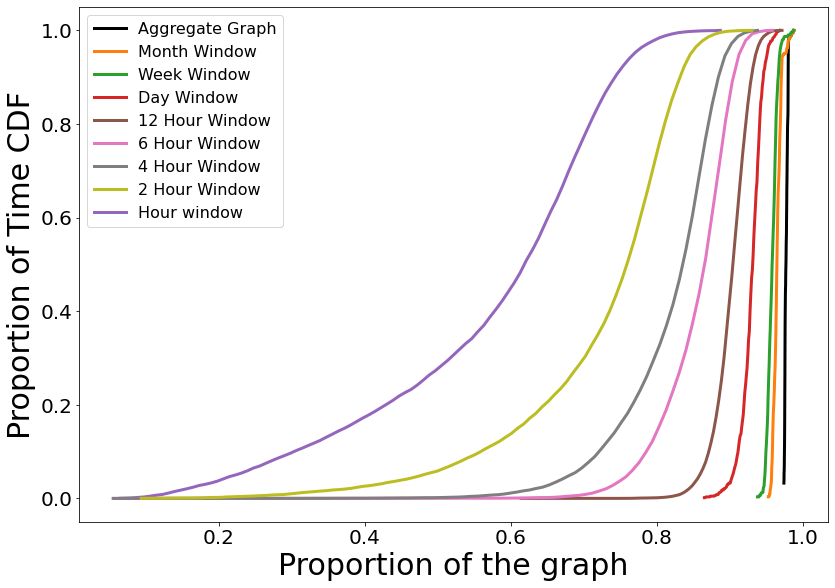

In [28]:
def proportionWindowCDFPlot(toPlot,title,x,y,scale,start,end):
    num_bins = 100
    
    windows = [2592000000,604800000,86400000]
    windows2 = [43200000,21600000,14400000,7200000]
    labels = ['Month Window','Week Window','Day Window']
    labels2 = ["12 Hour Window","6 Hour Window","4 Hour Window","2 Hour Window"]
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)

    with open('CC/nowindow.json') as json_file:
        color=next(ax._get_lines.prop_cycler)['color']
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x = x[x['total'] != 0]
        x['mean'] = x[toPlot].rolling(window=4,center=False).mean()
        counts, bin_edges = np.histogram (x[toPlot], bins=num_bins, normed=False)
        cdf = np.cumsum (counts)
        l,=plt.plot (bin_edges[1:], cdf/cdf[-1], linewidth=3, color='black')
        l.set_label("Aggregate Graph")

    with open('CC/bigCC.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        cc1 = cc1[cc1[toPlot] != 0]
        index = 0
        for i in windows:
            color=next(ax._get_lines.prop_cycler)['color']
            y = cc1[cc1['windowsize'] == i]
            y['mean'] = y[toPlot].rolling(window=4,center=False).mean()
            hours = str(int((i/3600000)))+" hour window"
            counts, bin_edges = np.histogram (y[toPlot], bins=num_bins, normed=False)
            cdf = np.cumsum (counts)
            l,=plt.plot (bin_edges[1:], cdf/cdf[-1], linewidth=3, color=color)
            l.set_label(labels[index])
            index +=1

    with open('CC/cc1hour.json') as json_file:
        color=next(ax._get_lines.prop_cycler)['color']
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        print(x.index)
        x =x[start:end]
        x = x[x['total'] != 0]
        x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
        counts, bin_edges = np.histogram (x[toPlot], bins=num_bins, normed=False)
        cdf = np.cumsum (counts)
        plt.plot(bin_edges[1:], cdf/cdf[-1],label="Hour window", color=color, linewidth=3)
            
    with open('CC/ccwindowsecondset.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1.sort_index()[start:end]
        cc1 = cc1[cc1[toPlot] != 0]
        index = 0
        for i in windows2:
            color=next(ax._get_lines.prop_cycler)['color']
            y = cc1[cc1['windowsize'] == i]
            y['mean'] = y[toPlot].rolling(window=4,center=False).mean()
            hours = str(int((i/3600000)))+" hour window"
            counts, bin_edges = np.histogram (y[toPlot], bins=num_bins, normed=False)
            cdf = np.cumsum (counts)
            l,=plt.plot (bin_edges[1:], cdf/cdf[-1], linewidth=3, color=color)
            l.set_label(labels2[index])
            index +=1

    handles,labels = ax.get_legend_handles_labels()
    hour = handles.pop(4)
    handles.append(hour)
    hour = labels.pop(4)
    labels.append(hour)

    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    
    ax.legend(handles, labels, fontsize=16)
    plt.tight_layout()
    plt.savefig("Graphs/ConnectedComponentsCDF.png")
    plt.show()



proportionWindowCDFPlot('proportion','Biggest Connected Components % of graph','Proportion of the graph', 
                        'Proportion of Time CDF','linear','2016-09-01', '2018-05-03')


## Diurnal activity as shown by the hourly window

Batching the data by hour of the day we can see some diurnal behaviour as it's a mostly US-based platform. 

### Initial box plot

Seaborns documentation: parameter `whis` controlling how far whiskers stretch. Upper whisker stretches to the furthest datapoint within `[UQ, UQ + whis*IQR]`

AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'

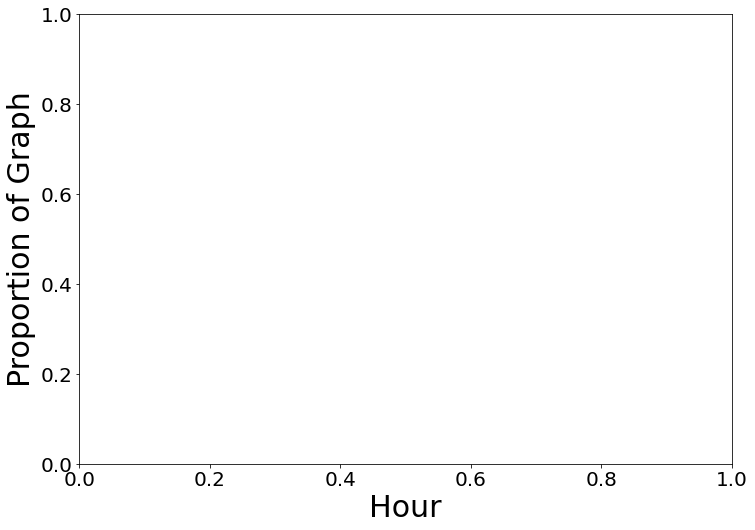

In [29]:
def diurnal_plot(toPlot, title, x, y, scale,start,end):
    
    windows = [31536000000,2592000000,604800000,86400000]
    #start = 1483228800000
    no_weeks = 10
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(1,1,figsize=a4_dims)
    #ax[0].set_title(title,fontsize=20)
    #ax.set_title("Boxplot of "+title,fontsize=30)
    #ax[0].set_xlabel(x,fontsize=20)
    ax.set_xlabel(x,fontsize=30)
    #ax[0].set_ylabel(y,fontsize=20)
    ax.set_ylabel(y,fontsize=30)
    #ax[0].set_yscale(scale)
    ax.set_yscale(scale)
    
    dfs = {}
    
    with open('CC/cc1hour.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x = x.set_index('time')
        x['Weekday Name'] = x.index.weekday_name
        x['Hour'] = x.index.hour
    #print(x.dtypes)
        x = x[x['total'] != 0]
        means = x.groupby(x.index.hour).mean()
        sds = x.groupby(x.index.hour).std()
        #ax[0].plot(means['Hour'],means[toPlot])
        #ax[0].fill_between(means['Hour'], means[toPlot]-sds[toPlot]/2.0, means[toPlot]+sds[toPlot]/2.0, alpha=0.3)
        
        ax=sns.boxplot(data=x, x='Hour', y=toPlot)
        plt.xlabel("Hour (UTC)")
        plt.rc('xtick',labelsize=20)
        plt.rc('ytick',labelsize=20)
        plt.ylabel(y,fontsize=30)
        plt.tight_layout()
        plt.savefig("Graphs/"+y.replace(" ","_")+".png")
        plt.show()
        
diurnal_plot('proportion','Largest Connected Component % of graph','Hour','Proportion of Graph','linear','2016-11-30', '2018-10-30')
diurnal_plot('biggest','Largest Connected Component Size','Hour','Largest connected Component','linear','2016-11-30','2018-10-30')
diurnal_plot('totalWithoutIslands','Total Connected Components','Hour','Total Connected Components','linear','2016-11-30','2018-10-30')

### Time-series analysis of the LCC in the hour window

This section explores deeper the existence of periodic/diurnal behaviour in the size/proportion of giant component size using fourier analysis. We will look first at the proportion data. 

The fourier transform and power spectrum of the shows peaks at the 24hr, 12hr, and 6hr frequencies.

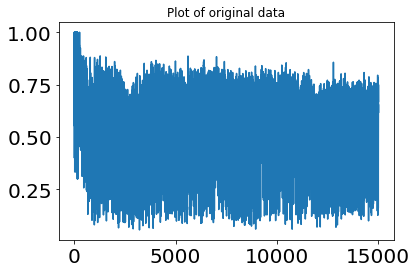

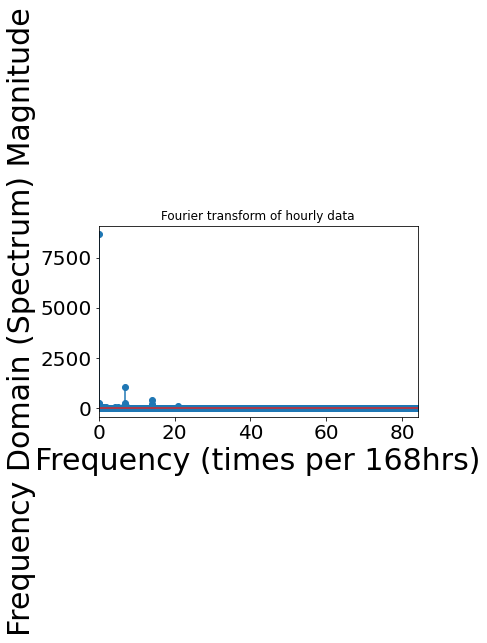

In [35]:
# Look at power spectrum of proportion data
from scipy import fftpack, signal

start, end = '2016-08-16','2018-05-30'
with open('CC/cc1hour.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x = x[start:end]
    json_file.close()

initial_arr = x.copy()
data_prop = np.array(x['proportion'])

# plot original data (shifted by mean)

plt.plot(range(len(data_prop)),data_prop)
plt.title('Plot of original data')
plt.show()

# get fourier series
fs = 168
x = fftpack.fft(data_prop)
# x is a vector of complex number eigenvalues
freqs = fftpack.fftfreq(len(data_prop))*fs

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(x))
ax.set_xlabel('Frequency (times per '+str(fs)+'hrs)')
ax.set_xlim(0,0.5*fs)
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
plt.title('Fourier transform of hourly data')
plt.tight_layout()
plt.show()

In [36]:
print(initial_arr[initial_arr['time']>1519174803000])

                              time  windowsize  biggest  total  \
index                                                            
2018-02-21 02:00:00  1519178400000     3600000      364     68   
2018-02-21 03:00:00  1519182000000     3600000      281     80   
2018-02-21 04:00:00  1519185600000     3600000      258     84   
2018-02-21 05:00:00  1519189200000     3600000       86    105   
2018-02-21 06:00:00  1519192800000     3600000      104     59   
...                            ...         ...      ...    ...   
2018-05-03 14:00:00  1525356000000     3600000      440    115   
2018-05-03 15:00:00  1525359600000     3600000      566     83   
2018-05-03 16:00:00  1525363200000     3600000      478     94   
2018-05-03 17:00:00  1525366800000     3600000      434    107   
2018-05-03 17:34:57  1525368897000     3600000      482    101   

                     totalWithoutIslands  totalIslands  proportion  \
index                                                                
2

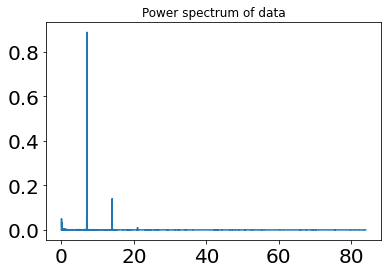

In [37]:
# Compute power spectrum for clearer picture
freqs, P_xx = signal.periodogram(data_prop, fs, scaling = 'density')
plt.plot(freqs, P_xx)
plt.title('Power spectrum of data')
plt.show()

Below is the inverse Fourier transform (IFT) of the first few frequencies, showing the 'hum'.

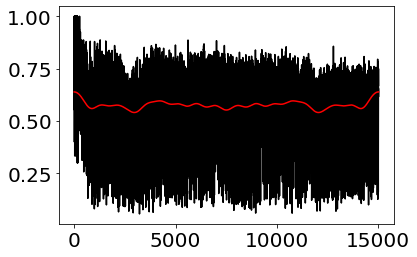

In [38]:
# Compute inverse fourier transform of first few frequencies.

tmp = np.zeros(len(x))
tmp[:20]=x[:20]
IFT = fftpack.ifft(tmp)
plt.plot(range(len(data_prop)),data_prop, color='black')
plt.plot(range(len(data_prop)),IFT,color='red')
plt.show()

The IFT of the largest magnitude 10 frequencies looks fairly as expected, looking like a sine wave with 24h period.

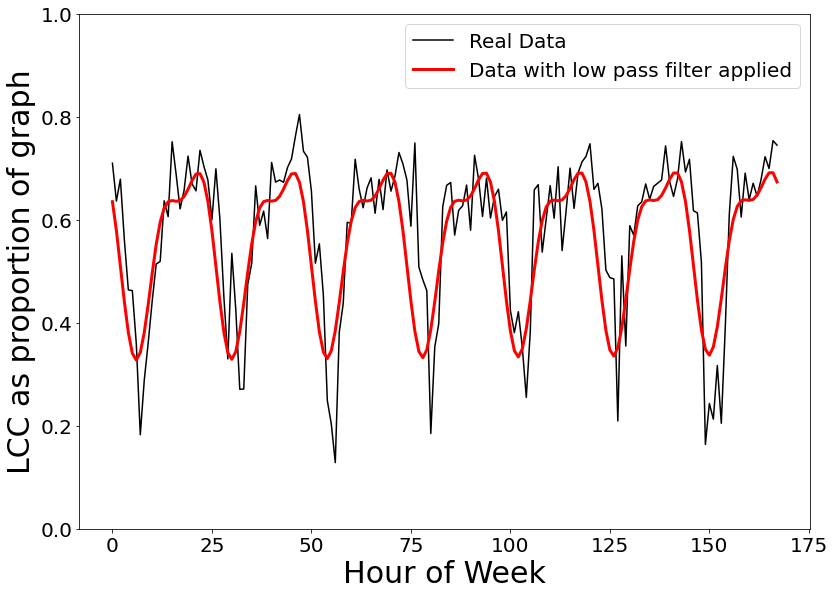

In [40]:
#First 10 harmonics against real data for 1 week
start = 13314
wl = 168
ix_full = np.argsort(-1*np.absolute(x))
res_full = np.absolute(x[ix_full])

tmp = np.zeros(len(x),dtype=np.complex)
tmp[ix_full[:10]]=x[ix_full[:10]]
res1 = np.fft.ifft(tmp)

fig, ax = plt.subplots(figsize=a4_dims)
plt.xlabel('Hour of Week', fontsize=30)
#plt.ylim(0.0,1.0)
plt.ylabel('LCC as proportion of graph',fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.plot(range(168),data_prop[start:start+wl],color='black', label = 'Real Data')
plt.plot(range(168),res1[start:start+wl],color='red',linewidth=3, label = 'Data with low pass filter applied')
plt.legend(fontsize=20)
plt.tight_layout()
plt.ylim(0,1)
plt.savefig("Graphs/LCC_timeseries.png")
plt.show()

If we allow the IFT of the largest 240 harmonics we actually see a second slightly smaller peak slightly before a bigger peak, suggesting the presence of a European userbase.

In [ ]:
#First 240 harmonics

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

tmp = np.zeros(len(x), dtype=np.complex)
tmp[ix_full[:240]]=x[ix_full[:240]]
res2 = np.fft.ifft(tmp)

plt.xlabel('Hour of week')

plt.plot(data_prop[start:start+wl],color='black')
plt.plot(np.real(res2[start:start+wl]),color='red',linewidth=3)
plt.show()

The following plot is the red line in the previous plot plotted against a 4hr behind version of itself -- it doesn't really add anything but I just want to keep the picture for it somewhere as it's quite pretty!

In [ ]:
# Look at the 4-lagged version of cleaned signal
res1_lagged = np.roll(np.real(res1),4)

plt.plot(np.real(res1), res1_lagged, linewidth=0.1)
plt.show()

This following subsection definitely needs more attention from me but is essentially doing the same process but for the absolute size of the LCC, and shows that if we look at the absolute size rather than proportion, we see not just a 24hr frequency but a weekly frequency (component is smaller at weekends)/

In [ ]:
# Let's do some the same process but this time with the "size of LCC" data

with open('CC/cc1hour.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    json_file.close()
    
data_biggest = signal.detrend(np.array(x['biggest']))

In [ ]:
plt.plot(range(len(data_biggest)),data_biggest)
plt.title('Plot of original data (detrended)')
plt.show()

# get fourier series
fs = 168
y = fftpack.fft(data_biggest)
# x is a vector of complex number eigenvalues
freqs = fftpack.fftfreq(len(data_biggest))*fs

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(y))
ax.set_xlabel('Frequency (times per '+str(fs)+'hrs)')
ax.set_xlim(0,0.5*fs)
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
plt.title('Fourier transform of hourly data')
plt.tight_layout()
plt.show()

In [ ]:
# Compute power spectrum for clearer picture
freqs, P_xx = signal.periodogram(data_biggest, fs, scaling = 'density')
plt.plot(freqs, P_xx)
plt.title('Power spectrum of data')
plt.show()

In [ ]:
# Compute inverse fourier transform of first few frequencies.

tmp = np.zeros(len(y))
tmp[:20]=y[:20]
IFT = fftpack.ifft(tmp)
plt.plot(range(len(data_biggest)),data_biggest, color='black')
plt.plot(range(len(data_biggest)),IFT,color='red')
plt.show()

In [ ]:
#First 10 harmonics against real data for 1 week

ix_full = np.argsort(-1*np.absolute(y))
res_full = np.absolute(y[ix_full])

tmp = np.zeros(len(y),dtype=np.complex)
tmp[ix_full[:50]]=y[ix_full[:50]]
res1 = np.fft.ifft(tmp)

plt.figure(figsize=(8,5))
plt.plot(range(168),data_biggest[1000:1168],color='black')
plt.plot(range(168),res1[1000:1168],color='red',linewidth=3)
plt.show()

In [ ]:
#First 240 harmonics

tmp = np.zeros(len(y), dtype=np.complex)
tmp[ix_full[:240]]=y[ix_full[:240]]
res2 = np.fft.ifft(tmp)

plt.plot(data_biggest[10000:10720],color='black')
plt.plot(np.real(res2[10000:10720]),color='red',linewidth=2)
plt.show()

In [ ]:
# See if lagged series without harmonics is still correlated.

without_harmonics = data_biggest - np.real(res2)

plt.stem(range(24), acf(without_harmonics,24))
plt.show()

In [ ]:
# Look at the 4-lagged version of cleaned signal
res1_lagged = np.roll(np.real(res2),4)

plt.plot(np.real(res2), res1_lagged, linewidth=0.1)
plt.show()

## Comparison with shuffled timestamps null model

Keep the same links but reorder their timestamps randomly, so that the rate of edge activity is conserved and that the aggregate graph is identical. For more detail on this null model, take a look at [Temporal Networks](https://arxiv.org/pdf/1108.1780.pdf), P. Holme, J. Saramaki (2011) under the heading Randomly Permuted Times (p17). 

### Proportion

We find that the value for the proportion is always smaller in the shuffled timestamps case than the real data, only slightly so for window sizes greater than a day, but largely so for the hour window. My thoughts are that this is due to the 'memory effect'/'edge persistence' in the real data, i.e. pairwise interactions are fairly bursty, and the chance of an interaction between two users decreases the longer it's been since the last interaction. In this way, we might expect to see a higher number of unique nodes by randomly sampling a number of edges throughout the whole time period than sampling the same number of edges but within a small time slice (i.e. a larger denominator in the 'proportion' for the shuffled than for unshuffled).

In [ ]:
def get_expected_size(n,m):
    sizes=np.zeros(5)
    for i in range(5):
        G = nx.gnm_random_graph(n, m)
        largest = max(nx.connected_components(G), key=len)
        sizes[i]=len(largest)
    return np.mean(sizes)


In [ ]:
def nullComparePlot(toPlot,x,y,scale,start,end,window,lims):
    windows = {"Year": 31536000000,"Month": 2592000000, "Week": 604800000, "Day": 86400000}
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)
    plt.ylim(lims)
    
    if window=="Hour":
        with open('degree/degreehours.json') as json_file:
            x = json.load(json_file)
            x= pd.DataFrame(x['views'])
            x['index'] = pd.to_datetime(x['time'],unit='ms')
            x['time'] = pd.to_datetime(x['time'],unit='ms')
            x.set_index('index', inplace=True)
            x =x[start:end]
            x['mean'] =x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
            x['mean_prop']= x['mean']/x['vertices']
            #plt.fill_between(x['time'],np.array(x['mean'])-np.array(x['sd']), np.array(x['mean'])+np.array(x['sd']),alpha=0.3)
            #print(x['expected'])
            if toPlot == 'proportion':
                ax.plot(x['time'],x['mean_prop'], linestyle='--', linewidth=3, label='Erdos-Renyi')
            if toPlot == 'biggest':
                ax.plot(x['time'],x['mean'], linestyle='--', linewidth=3, label='Erdos-Renyi')
            json_file.close()
        with open('CC/cc1hour.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            cc1.plot(x='time', y=toPlot,ax=ax, color='black', linewidth=3, label="Real Data")
    
        with open('CC/sortedCChour.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            cc1.plot(x='time', y=toPlot,ax=ax, linestyle=':', linewidth=3, label="Shuffled Timestamps")
            
    elif window =="4 Hour":
        with open('CC/ccwindowsecondset.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize']==14400000]
            y.plot(x='time', y=toPlot,ax=ax, label="Real Data")
            
        with open('CC/sortedhourslotcc.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize']==14400000]
            y.plot(x='time', y=toPlot,ax=ax, label="Shuffled Timestamps")
            
    elif window =="6 Hour":
        with open('CC/ccwindowsecondset.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize']==21600000]
            y.plot(x='time', y=toPlot,ax=ax, label="Real Data")
            
        with open('CC/sortedhourslotcc.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize']==21600000]
            y.plot(x='time', y=toPlot,ax=ax, label="Shuffled Timestamps")
            
    elif window =="12 Hour":
        with open('CC/ccwindowsecondset.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize']==43200000]
            y.plot(x='time', y=toPlot,ax=ax, label="Real Data")
            
        with open('CC/sortedhourslotcc.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize']==43200000]
            y.plot(x='time', y=toPlot,ax=ax, label="Shuffled Timestamps")
            
    else:
        with open('CC/bigCC.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize'] == windows[window]]
            y.plot(x='time', y=toPlot,ax=ax, label="Real Data")
            
        with open('degree/degreewindows.json') as json_file:
            x = json.load(json_file)
            x= pd.DataFrame(x['views'])
            x['index'] = pd.to_datetime(x['time'],unit='ms')
            x['time'] = pd.to_datetime(x['time'],unit='ms')
            x.set_index('index', inplace=True)
            x =x[start:end]
            x = x[x['windowsize']==windows[window]]
            x['mean'] =x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
            x['mean_prop']= x['mean']/x['vertices']
            #plt.fill_between(x['time'],np.array(x['mean'])-np.array(x['sd']), np.array(x['mean'])+np.array(x['sd']),alpha=0.3)
            #print(x['expected'])
            ax.plot(x['time'],x['mean_prop'], linestyle='--', linewidth=3, label='Erdos-Renyi')
            json_file.close()

        with open('CC/sortedCC.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize'] == windows[window]]
            y.plot(x='time', y=toPlot,ax=ax, label="Shuffled Timestamps")
        
    ax.legend(fontsize=20,framealpha=1,loc='center right')
    plt.tight_layout()
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.xlabel("Date")
    plt.savefig("Graphs/"+toPlot+window+".png")

### Proportion: Hour window

In [ ]:
nullComparePlot('proportion','Date','Proportion','linear','2017-09-30 23:00:00','2017-10-30','Hour',[0.0,1.0])

### Proportion: 4 Hour window

In [ ]:
nullComparePlot('proportion','Date','Proportion','linear','2017-09-30 23:00:00','2017-10-30','4 Hour',[0.0,1.0])

### Proportion 6 Hour

In [ ]:
nullComparePlot('proportion','Date','Proportion','linear','2017-09-30 23:00:00','2017-10-30','6 Hour',[0.0,1.0])

### Proportion: Day window

In [ ]:
nullComparePlot('proportion','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Day',[0.6,1.0])

### Proportion: Week Window

In [ ]:
nullComparePlot('proportion','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Week',[0.6,1.0])

### Proportion: Month window

In [ ]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Month',[0.6,1.0])

### Proportion: Year window

In [ ]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Year',[0.6,1.0])

### Size of the largest connected component

For this part we instead plot the absolute size of the largest connected component for different windows. Like the proportion, the LCC size is smaller for the shuffled data than the real in the hour window, but confusingly this order switches going up to the day, week and month windows. 

For the day, week and month window, I suspect that 'memory effect' might explain this too, in that you're more likely to sample 'weak ties' if sampling from the whole time period as opposed to the same number but from a small time interval.

### Raw size of LCC: Hour window

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2017-09-30 23:00:00','2017-10-30','Hour',[0,450])

### Raw size of LCC: 4 Hour Window

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2017-09-30 23:00:00','2017-10-30','4 Hour',[0,1000])

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2017-09-30 23:00:00','2017-10-30','6 Hour',[0,1500])

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2017-09-30 23:00:00','2017-10-30','12 Hour',[0,2000])

### Raw size of LCC: Day window

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Day',[0,10000])

### Raw size of LCC: Week window

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Week',[0,50000])

### Raw size of LCC: Month window

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Month',[0,50000])

### Raw size of LCC: Year window

In [ ]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Year',[0,100000])

## Comparison with Erdos-Renyi Reference model

We compare also (on a smaller time interval because of time constraints!) the size of the LCC for the real data with that of an Erdos-Renyi random graph with the same number of nodes and edges.

Specifically we generate, for each window size and time, a graph with the same number of nodes and edges as the real data, with the edges assigned at random, and compare the size of the LCC of this with the real data.

For each window size, the LCC is consistently overestimated by the E-R model, which may be due to some strong underlying community structure, whereby the second, third etc largest connected components in the real data are non-negligible in size.

### Hour window

In [ ]:
# Size of largest connected component compared to expected in an E-R Graph

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)

import networkx as nx

def get_expected_size(n,m):
    sizes=np.zeros(5)
    for i in range(5):
        G = nx.gnm_random_graph(n, m)
        largest = max(nx.connected_components(G), key=len)
        sizes[i]=len(largest)
    return np.mean(sizes)

start, end = '2017-9-23 23:00:00','2017-09-30 23:00:00'

with open('degree/degreehours.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['mean'] =x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    x['mean_prop']= x['mean']/x['vertices']
    #plt.fill_between(x['time'],np.array(x['mean'])-np.array(x['sd']), np.array(x['mean'])+np.array(x['sd']),alpha=0.3)
    #print(x['expected'])
    ax.plot(x['time'],x['mean_prop'],label='Expected size of LCC')
    json_file.close()
    
with open('CC/cc1hour.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='proportion',ax=ax, label='Size of LCC')
    json_file.close()

plt.xlabel('Time',fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.legend(fontsize=20)
plt.savefig("Graphs/largest_vs_expected_hour.png")
plt.show()

### Day window

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)

with open('degree/degreewindows.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==86400000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['mean'] =x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #print(x['expected'])
    #ax.fill_between(x['time'],np.array(x['mean'])-np.array(x['sd']), np.array(x['mean'])+np.array(x['sd']),alpha=0.3)
    ax.plot(x['time'],x['mean'],label='Expected size of LCC')
    json_file.close()
    
with open('CC/bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==86400000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()
    
plt.xlabel('Time',fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.legend(fontsize=20)
plt.show()

### Week window

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)
ax.set_yscale('linear')

with open('degree/degreewindows.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==604800000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['expected']=x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #print(x['expected'])
    x.plot(x='time',y='expected',ax=ax,label='Expected size of LCC')
    json_file.close()
    
with open('CC/bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==604800000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()

plt.xlabel('Time',fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.legend(fontsize=20)
plt.show()

### Month window

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)
plt.xlabel('Time',fontsize=20)
ax.set_yscale('linear')

with open('degree/degreewindows.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==2592000000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['expected']=x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #print(x['expected'])
    x.plot(x='time',y='expected',ax=ax,label='Expected size of LCC')
    json_file.close()
    
with open('CC/bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==2592000000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()
    
plt.xlabel('Time',fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.legend(fontsize=20)
plt.show()

# Dynamics of top 20 users

For each window size and window, we obtain the top 20 users in terms of in-degree. Is it the case that some users dominate for long periods, or is it more dynamic?

### Jaccard Similarity.

For two sets A and B, the Jaccard similarity is given by |A n B| / |A u B| measuring their percentage overlap.

In [41]:
def jaccard_similarity(list1, list2):
    if list1 is None or list2 is None:
        return 0.0
    list1, list2 = set(list1), set(list2)
    size = min(len(list1),len(list2))
    intersection_size = len(list1.intersection(list2))
    #union_size=len(list1)+len(list2)-intersection_size
    if size==0:
        return 0.0
    else: return intersection_size/size

## Stability over consecutive windows

For each window size, we calculate the Jaccard similarity between the pairs of consecutive non-overlapping windows' top 20 users. The lower plot shows the mean JS for each window size, but as the error bars overlap and as the number of datapoints drops vastly for each window theres nothing much concrete we can say about it yet.

In [42]:
def get_users(cell):
    if len(cell)==0:
        return []
    return pd.DataFrame(cell)['id']

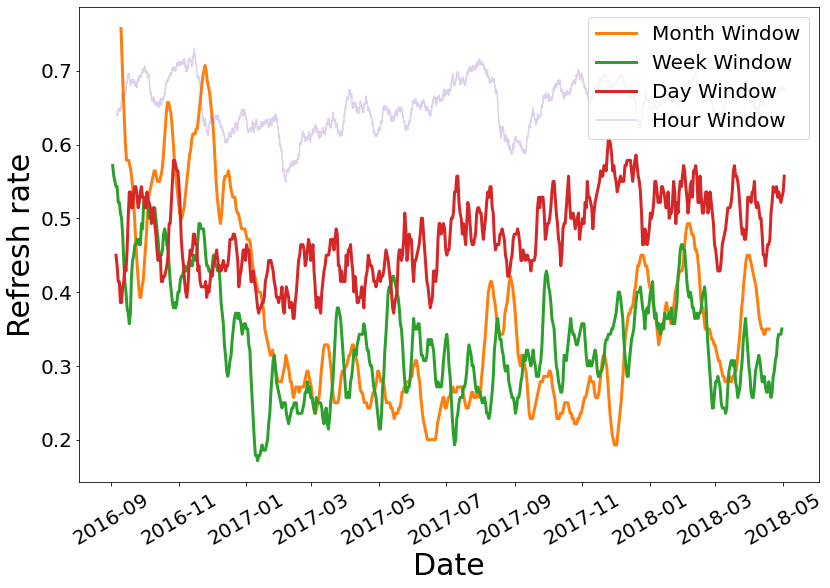

In [43]:
def get_users(cell):
    if len(cell)==0:
        return []
    return pd.DataFrame(cell)['id']

def rank_jaccard_fast(x, y, title, scale):
    windows = [2592000000,604800000,86400000]
    labels = ['Month Window','Week Window','Day Window', 'Hour Window']
    a4_dims = (11.7, 8.27)
    day_length=86400000
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title, size=30)
    plt.xlabel(x, size=30)
    plt.ylabel(y, size=30)
    ax.set_yscale(scale)
    
    start, end = '2016-08-30 23:00:00','2018-10-30'
    
    means=np.zeros(5)
    sds=np.zeros(5)
    
    with open('degree/degreewindows.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    color=next(ax._get_lines.prop_cycler)['color']
    
    index = 0
    for i in windows:
        color=next(ax._get_lines.prop_cycler)['color']
        n = round(i/day_length)
        y = degs[degs['windowsize'] == i]
        #y = y.iloc[::n,:]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        y['nexttop'] = y['topusers'].shift(n)
        for k in range(n):
            y['nexttop'][k]=[]
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
        mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[10]['time'] + timedelta(microseconds=1000*i))
        y=y[mask]
        y['time'] = y['time'] - timedelta(microseconds=500*i)
        y.set_index('time',inplace=True)
        means[index]=np.mean(y['jaccard'])
        sds[index]=np.std(y['jaccard'])

        ax.plot(1 - y['jaccard'].rolling(7).mean(), label=labels[index], color=color, linewidth=3)
        index +=1
    
    with open('degree/degreehours.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
    
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    color=next(ax._get_lines.prop_cycler)['color']
    
    y = degs
    y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    y['nexttop'] = y['topusers'].shift(1)
    y['nexttop'][0]=[]

    y['jaccard']= y.apply(lambda x: 0.0, axis=1)
    y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
    mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[10]['time'] + timedelta(microseconds=1000*i))
    y=y[mask]
    y['time'] = y['time'] - timedelta(microseconds=500*i)
    y.set_index('time',inplace=True)
    means[index]=np.mean(y['jaccard'])
    sds[index]=np.std(y['jaccard'])

    ax.plot(1 - y['jaccard'].rolling(168).mean(), label=labels[index], color=color, alpha=0.3)

    plt.legend(fontsize=20, loc='upper right')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarity.png')
    plt.show()
    
#     fig, ax = plt.subplots(figsize=a4_dims)
#     windows = [31536000000,2592000000,604800000,86400000,3600000]
#     windows.reverse()

#     new_means = np.flip(means)
#     new_sds = np.flip(sds)
    
#     labels.reverse()
#     ax.bar(np.arange(5), new_means, yerr=new_sds, align='center', alpha=0.5, ecolor='black')
#     plt.xlabel('Window Size',size=20)
#     ax.set_xticks(np.arange(5))
#     ax.set_xticklabels(labels,size=20,rotation=30)
#     plt.ylabel('Similarity between consecutive windows', size=20)
#     plt.savefig('Graphs/JaccardMeanSD.png')
#     plt.show()
    
    
rank_jaccard_fast("Date", "Refresh rate", "Jaccard similarity index of consecutive node rankings", 'linear')

## Effect of shuffling timestamps

As with the connected components, we look at the effect of randomly shuffling the timestamps. It seems to have a "smoothing effect", suggesting that in the original data, many of the users who reach the top 20 may only do so for a short period of time.

In [ ]:
def rank_jaccard_shuffled(x, y, title, scale):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window', 'Hour Window']
    a4_dims = (11.7, 8.27)
    day_length=86400000
    fig, ax = plt.subplots(figsize=a4_dims)
    jaccard=pd.DataFrame({'Window Size':[], 'Jaccard':[]})
    #plt.title(title, size=30)
    plt.xlabel(x, size=20)
    plt.ylabel(y, size=20)
    ax.set_yscale(scale)
    
    start, end = '2016-08-30 23:00:00','2018-10-30'
    
    means=np.zeros(5)
    sds=np.zeros(5)
    
    with open('degree/degreesorted.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    index = 0
    for i in windows:
        n = round(i/day_length)
        y = degs[degs['windowsize'] == i]
        #y = y.iloc[::n,:]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        y['nexttop'] = y['topusers'].shift(n)
        for k in range(n):
            y['nexttop'][k]=[]
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
        mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=1000*i))
        y=y[mask]
        y['time'] = y['time'] - timedelta(microseconds=500*i)
        means[index]=np.mean(y['jaccard'])
        sds[index]=np.std(y['jaccard'])
        jaccard['Time']=y['time'] - timedelta(microseconds=500*i)
        jaccard[labels[index]]=y['jaccard']
        
        ax.plot(y['time'],y['jaccard'], label=labels[index])
        index +=1
    
    jaccard.set_index('Time',inplace=True)
    
    with open('degree/degreesortedhour.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
    
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    y = degs
    y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    y['nexttop'] = y['topusers'].shift(1)
    y['nexttop'][0]=[]

    y['jaccard']= y.apply(lambda x: 0.0, axis=1)
    y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
    
    mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=1000*i))
    y=y[mask]
    
    means[index]=np.mean(y['jaccard'])
    sds[index]=np.std(y['jaccard'])
    jaccard['Time']=y['time']
    jaccard[labels[index]]=y['jaccard']

    ax.plot(y['time'],y['jaccard'], label=labels[index])
    
    print(means)
    print(sds)

    plt.legend(fontsize=20, loc='lower right')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarityShuffled.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=a4_dims)
    windows = [31536000000,2592000000,604800000,86400000,3600000]
    windows.reverse()

    new_means = np.flip(means)
    new_sds = np.flip(sds)
    
    labels.reverse()
    print(labels)
    ax.bar(np.arange(5), new_means, yerr=new_sds, align='center', alpha=0.5, ecolor='black')
    plt.xlabel('Window Size',size=20)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels,size=20,rotation=30)
    plt.ylabel('Similarity between consecutive windows', size=20)
    plt.savefig('Graphs/JaccardMeanSDShuffled.png')
    plt.show()
    
    
rank_jaccard_shuffled("Date", "Similarity", "Jaccard similarity index of consecutive node rankings", 'linear')

## Comparison with reference point

We also compute the similarity (for the real dataset) between top 20 users in each window size and the top 20 all-time top users at a reference point around Nov 16. We find:
* By the end of the time series, even in the largest window nearly all the top 20 users have been replaced, with the JS dropping to 0.1
* Even at the same time as the reference point, there are different top 20 users in smaller window sizes.

31536000000
2592000000
604800000
86400000


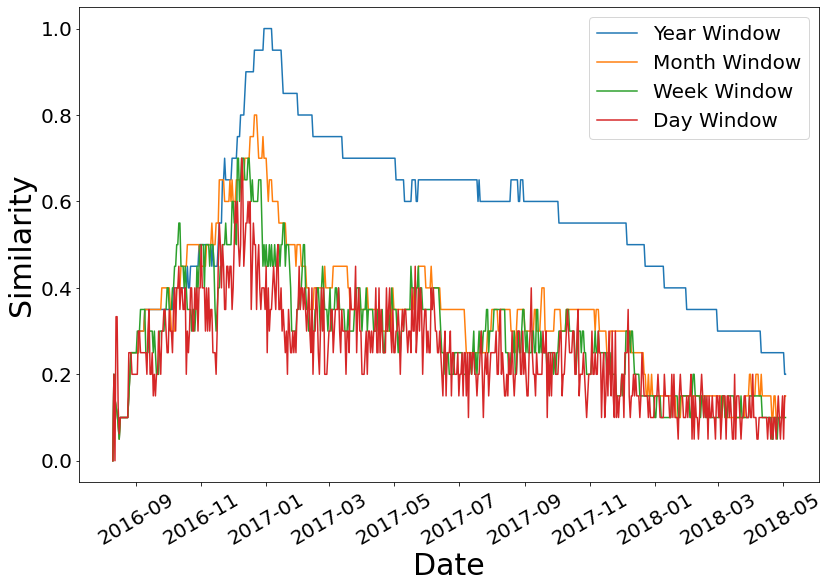

In [44]:
def get_users(cell):
    if len(cell)==0:
        return []
    return pd.DataFrame(cell)['id']

def rank_jaccard_year_comparison(x, y, title, scale):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    jaccard=pd.DataFrame({'Window Size':[], 'Jaccard':[]})
    #plt.title(title, size=30)
    plt.xlabel(x, size=30)
    plt.ylabel(y, size=30)
    ax.set_yscale(scale)
    
    with open('degree/degreewindows.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    #get year comparison:
    year = degs[degs['windowsize']==31536000000]
    jan17top = get_users(year['bestusers']['2017-01-01 23:00:00'])
    
    index=0
    for i in windows:
        print(i)
        y = degs[degs['windowsize'] == i]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],jan17top), axis=1)
        
        ax.plot(y['time'],y['jaccard'], label=labels[index])
        index +=1        
        
    plt.legend(fontsize=20, loc='upper right')
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarityJan17.png')
    plt.show()        
    
rank_jaccard_year_comparison('Date','Similarity','Similarity','linear')

## For how long do users enter the top 20?

For each user who has ever been in the top 20 in any window, we count the number of windows (for each size) in which they appear in the top 20. For example, 90% of these users appear in the daily top 20 for less than 10% of the time period. Needs ironing out a bit I think as the explanation takes *me* ages to get my head around!

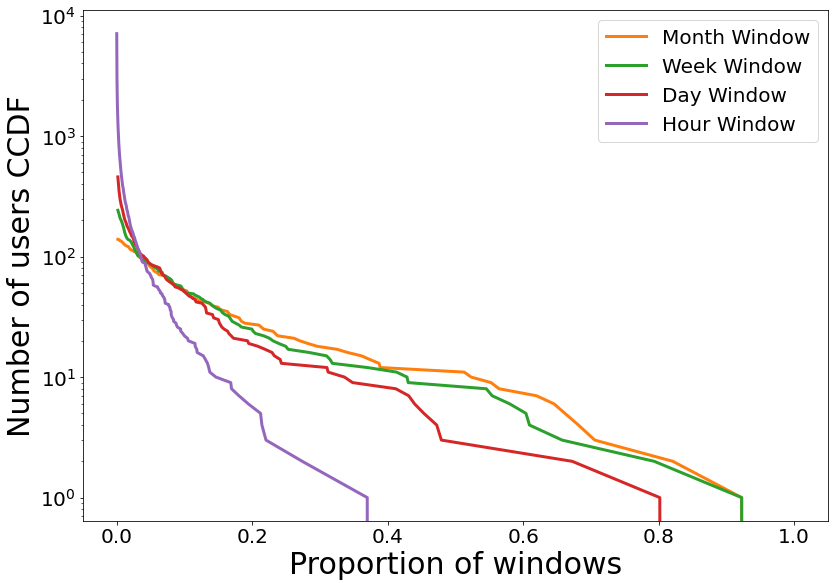

In [46]:
from collections import Counter
from itertools import chain

def how_many_windows(x,y,title,scale):
    
    start, end = '2016-09-30 23:00:00','2018-10-30'
    
    windows = [2592000000,604800000,86400000]
    labels = ['Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title, size=30)
    plt.xlabel(x, size=30)
    plt.ylabel(y, size=30)
    ax.set_yscale(scale)
    
    color=next(ax._get_lines.prop_cycler)['color']
    
    with open('degree/degreewindows.json') as json_file:
        degs1 = json.load(json_file)
        json_file.close()
    with open('degree/degreesorted.json') as json_file:
        degs2 = json.load(json_file)
        json_file.close()
        
    with open('degree/degreehours.json') as json_file:
        degs3 = json.load(json_file)
        json_file.close()
    
    degslist = [degs1, degs2]
    styles = ['-', '--']
    
    for j in range(1):
        degs = degslist[j]
    
        degs = pd.DataFrame(degs['views'])
        degs['time'] = pd.to_datetime(degs['time'],unit='ms')
        degs['index'] = pd.to_datetime(degs['time'],unit='ms')
        degs.set_index('index', inplace=True)


        index = 0
        for i in windows:
            color=next(ax._get_lines.prop_cycler)['color']
            y = degs[degs['windowsize'] == i]
            y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
            mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=1000*i))
            y=y[mask]
            total_windows = len(y)
            users_count = Counter(chain.from_iterable(set(row) for row in y['topusers']))
            meta = Counter(users_count.values())
            x1,y1 = zip(*sorted(meta.items()))
            x1 = np.array(x1)/total_windows
            y1 = np.cumsum(np.array(y1))
            ccdf = len(users_count.items())-y1
            ax.plot(x1, ccdf, label=labels[index], linewidth=3, linestyle = styles[j],color=color)
            index+=1
            
    color=next(ax._get_lines.prop_cycler)['color']
    degs = degs3
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    y = degs
    y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=360000000))
    y=y[mask]
    total_windows = len(y)
    users_count = Counter(chain.from_iterable(set(row) for row in y['topusers']))
    meta = Counter(users_count.values())
    x1,y1 = zip(*sorted(meta.items()))
    x1 = np.array(x1)/total_windows
    y1 = np.cumsum(np.array(y1))
    ccdf = len(users_count.items())-y1
    ax.plot(x1, ccdf, label='Hour Window', linewidth=3, color=color, linestyle = styles[0])
        
    plt.legend(loc='upper right', fontsize=20)
    plt.tight_layout()
    plt.savefig("Graphs/top20CCDF.png")
    plt.show()
    
how_many_windows('Proportion of windows','Number of users CCDF','lol','log')

# OLD STUFF

In [ ]:



windows = [31536000000,2592000000,604800000,86400000]
with open('bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x = x[x['total'] != 0]
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title('Biggest Connected Components % of graph')
    plt.xlabel('Date')
    plt.ylabel('Proportion of Graph')
    for i in windows:
        y = x[x['windowsize'] == i]
        y['mean'] = y['proportion'].rolling(window=4,center=False).mean()
        hours = str(int((i/3600000)))+" hour window"
        y.plot(x='time', y='mean',ax=ax, label=hours)
    plt.show()





windows = [31536000000,2592000000,604800000,86400000]
y=0
x=0
z=0
a=0
with open('bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x = x[x['total'] != 0]
    
with open('bigCC2.json') as json_file:
    y = json.load(json_file)
    y= pd.DataFrame(y['views'])
    y['time'] = pd.to_datetime(y['time'],unit='ms')
    y = y[y['total'] != 0]
    
with open('bigCC3.json') as json_file:
    z = json.load(json_file)
    z = pd.DataFrame(z['views'])
    z['time'] = pd.to_datetime(z['time'],unit='ms')
    z = z[z['total'] != 0]
    
with open('bigCC4.json') as json_file:
    a = json.load(json_file)
    a = pd.DataFrame(a['views'])
    a['time'] = pd.to_datetime(z['time'],unit='ms')
    a = a[a['total'] != 0]
    

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Time taken to process view')
plt.xlabel('Date')
plt.ylabel('Time in Milliseconds')
x.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows")
y.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows with caching")
z.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows Parallel")
a.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows vote")


plt.show()

In [ ]:
def percentagePlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000, 86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)
    
    color=next(ax._get_lines.prop_cycler)['color']

    with open('degree/degreewindows.json') as json_file:
        with open('degree/degreesorted.json') as json_2:
            cc1 = json.load(json_file)
            cc2 = json.load(json_2)
            cc1= pd.DataFrame(cc1['views'])
            cc2= pd.DataFrame(cc2['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc2['time'] = pd.to_datetime(cc2['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc2['index'] = pd.to_datetime(cc2['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc2.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc2=cc2[start:end]
            index = 0
            for i in windows:
                color=next(ax._get_lines.prop_cycler)['color']
                y = cc1[cc1['windowsize'] == i]
                z = cc2[cc2['windowsize'] == i]
                y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
                z['avgdeg']= np.where(z['vertices']<1, z['vertices'], 2*z['edges']/z['vertices'])
                z['perc'] = np.where(z[toPlot]<1, 0, 100.0*y[toPlot]/z[toPlot])
                #y = y[y[toPlot] != 0]
                z.plot(x='time', y='perc',ax=ax, label=labels[index], color = color, linestyle="-", alpha=0.8)
                index +=1

    with open('degree/degreehours.json') as json_file:
        with open('degree/degreesortedhour.json') as json_2:
            color=next(ax._get_lines.prop_cycler)['color']
            x = json.load(json_file)
            y = json.load(json_2)
            x= pd.DataFrame(x['views'])
            y= pd.DataFrame(y['views'])
            x['index'] = pd.to_datetime(x['time'],unit='ms')
            y['index'] = pd.to_datetime(y['time'],unit='ms')
            x['time'] = pd.to_datetime(x['time'],unit='ms')
            y['time'] = pd.to_datetime(y['time'],unit='ms')
            x.set_index('index', inplace=True)
            y.set_index('index', inplace=True)
            x =x[start:end]
            y =y[start:end]
            x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
            y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
            y['perc'] = np.where(y[toPlot]<1, 0, 100.0*x[toPlot]/y[toPlot])
            x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
            y['hour'] = y.apply(lambda row: int(row['time'].hour),axis=1)
            x = x[x[toPlot] != 0]
            y = y[y[toPlot] != 0]
            y.plot(x='time', y='perc',ax=ax, color=color, label='Hour', alpha=0.3)
        
    #plt.axvline('2016-11-09',linestyle='')
    #plt.axvline('2017-08-11')
    #plt.axvline('2017-08-13')
    plt.legend(fontsize=20, loc='upper left')
    plt.xlabel('Date',fontsize=30)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.savefig('graphs/'+toPlot+'.png')
    plt.show()

In [ ]:
percentagePlot('edges','Number of Vertices','Date','Percentage against shuffled','linear','2016-09-30 23:00:00','2018-10-30')

In [13]:
from matplotlib import gridspec
from matplotlib import ticker as mticker

def getNewVsExistingDF():
    windows = [2592000000,604800000, 86400000]

    with open('degree/degrees.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        aggr = x
        aggr.set_index('index', inplace=True)
        aggr.to_csv("degree/Aggregate.csv")
        
    with open('degree/degreewindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        y=cc1
        index = 0
        y['diffSize']= y['windowsize']/86400000
        y['newUsers']= aggr['vertices'].diff(y['diffSize'])
        y['newEdges']= aggr['edges'].diff(y['diffSize'])
        #mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(microseconds=1000*y['windowSize']))
        #y=y[mask]
        y['propNewUsers'] = np.where(y['vertices']<1,1,y['newUsers']/y['vertices'])
        y['propNewEdges'] = np.where(y['edges']<1,1,y['newEdges']/y['edges'])
        #y['time'] = y['time'] - timedelta(microseconds=500*i)
        #y.set_index('time',inplace=True)
        y.to_csv("degree/NewVsExistingWindows.csv")
                
    otherwindows = [15768000000, 7884000000]
    otherlabels = ['6 Month Window', '3 Month Window']
    with open('degree/2-3-4-6monthdegreerankingretry.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        y=cc1
        index = 0
        y['diffSize']= y['windowsize']/86400000
        y['newUsers']= aggr[aggr['windowsize']==y['windowsize']]['vertices'].diff(y['diffSize'])
        y['newEdges']= aggr['edges'].diff(y['diffSize'])
        #mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(microseconds=1000*y['windowSize']))
        #y=y[mask]
        y['propNewUsers'] = np.where(y['vertices']<1,1,y['newUsers']/y['vertices'])
        y['propNewEdges'] = np.where(y['edges']<1,1,y['newEdges']/y['edges'])
        #y['time'] = y['time'] - timedelta(microseconds=500*i)
        #y.set_index('time',inplace=True)
        y.to_csv("degree/NewVsExistingOtherWindows.csv")
                
#     with open('degree/degreehours.json') as json_file:
#         with open('degree/degreesortedhour.json') as json_2:
#             color=next(ax1._get_lines.prop_cycler)['color']
#             x = json.load(json_file)
#             y = json.load(json_2)
#             x= pd.DataFrame(x['views'])
#             y= pd.DataFrame(y['views'])
#             x['index'] = pd.to_datetime(x['time'],unit='ms')
#             y['index'] = pd.to_datetime(y['time'],unit='ms')
#             x['time'] = pd.to_datetime(x['time'],unit='ms')
#             y['time'] = pd.to_datetime(y['time'],unit='ms')
#             x.set_index('index', inplace=True)
#             y.set_index('index', inplace=True)
#             x =x[start:end]
#             y =y[start:end]
#             #x['prop_new'] = np.where(x[toPlot]<1,1,x['new']/x[toPlot])
#             x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
#             y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
#             x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
#             y['hour'] = y.apply(lambda row: int(row['time'].hour),axis=1)
#             x = x[x[toPlot] != 0]
#             y = y[y[toPlot] != 0]
#             x['time'] = x['time'] - timedelta(microseconds=500*3600000)
#             x.plot(x='time', y=toPlot,ax=ax1, color=color, label="Hour window", linewidth=3)
#             #x.plot(x='time', y="prop_new",ax=ax0, color=color, label="Hour window")
#             #y.plot(x='time', y=toPlot,ax=ax, color=color, label='_nolegend_',linestyle="--", alpha=0.8)

    


In [14]:
getNewVsExistingDF()

TypeError: cannot convert the series to <class 'int'>

KeyboardInterrupt: 

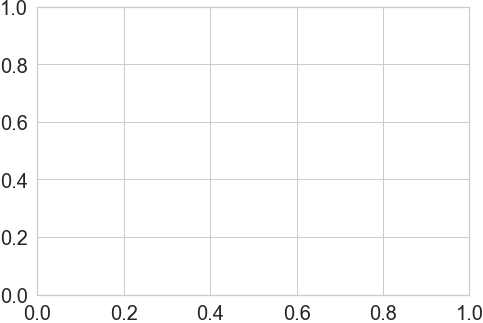

In [37]:
G = nx.gnm_random_graph(9000,8000)
biggest = max(nx.connected_components(G), key=len)
H = G.subgraph(list(biggest))
lengths = nx.single_source_shortest_path(G,0)
p = max(lengths.values(),key=len)
print(len(p))